# Exploratory data analysis on Airbnb data

This notebook explores the files containing information on Airbnb. The goal of this task is to understand file structure in order to design a database schema. The following diagram summarises the coming steps.

![EDA_steps](images/EDA-airbnb_notebook.png)

## Initialisation

In [65]:
### Import modules

import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
### Constants

CSV_PATH = './OriginalData_csv/'

## Understanding file content

In [3]:
### Import samples of files

df_calendar = pd.read_csv(CSV_PATH + 'calendar.csv')
df_listings = pd.read_csv(CSV_PATH + 'listings.csv')
df_listings_2 = pd.read_csv(CSV_PATH + 'listings-2.csv')
df_neighbourhoods = pd.read_csv(CSV_PATH + 'neighbourhoods.csv')
df_reviews = pd.read_csv(CSV_PATH + 'reviews.csv')
df_reviews_2 = pd.read_csv(CSV_PATH + 'reviews-2.csv')

# Display columns for each df
print('Columns of files:\n')
print('calendar: %s rows, %s columns' % df_calendar.shape)
print('listings: %s rows, %s columns' % df_listings.shape)
print('listings 2: %s rows, %s columns' % df_listings_2.shape)
print('neighbourhoods: %s rows, %s columns' % df_neighbourhoods.shape)
print('reviews: %s rows, %s columns' % df_reviews.shape)
print('reviews 2: %s rows, %s columns' % df_reviews_2.shape)

Columns of files:

calendar: 24322724 rows, 7 columns
listings: 66641 rows, 74 columns
listings 2: 66641 rows, 18 columns
neighbourhoods: 33 rows, 2 columns
reviews: 1043004 rows, 6 columns
reviews 2: 1043004 rows, 2 columns


### Review content

Since 2 review files were found, inspection is needed to understand their differences and uses.

In [4]:
### Display size of each df

print('Review files:\n')
print('review: %s rows, %s columns' % df_reviews.shape)
print('review 2: %s rows, %s columns' % df_reviews_2.shape)

Review files:

review: 1043004 rows, 6 columns
review 2: 1043004 rows, 2 columns


In [60]:
### Sample of review file

print('Head of reviews')
print(df_reviews.head())
print('\nHead of reviews 2')
print(df_reviews_2.head())

Head of reviews
   listing_id      id        date  reviewer_id reviewer_name  \
0       13913   80770  2010-08-18       177109       Michael   
1       13913  367568  2011-07-11     19835707       Mathias   
2       13913  529579  2011-09-13      1110304       Kristin   
3       13913  595481  2011-10-03      1216358       Camilla   
4       13913  612947  2011-10-09       490840         Jorik   

                                            comments  
0  My girlfriend and I hadn't known Alina before ...  
1  Alina was a really good host. The flat is clea...  
2  Alina is an amazing host. She made me feel rig...  
3  Alina's place is so nice, the room is big and ...  
4  Nice location in Islington area, good for shor...  

Head of reviews 2
   listing_id        date
0       13913  2010-08-18
1       13913  2011-07-11
2       13913  2011-09-13
3       13913  2011-10-03
4       13913  2011-10-09


In [7]:
### Understanding review2 file

print('Total rows of raw file reviews2:', df_reviews_2.shape[0])
print('Total unique rows in reviews2:', df_reviews_2.drop_duplicates().shape[0])

# Grouping to observe duplicated values
df_reviews2_unique = df_reviews_2.groupby(['listing_id', 'date'],
                                         as_index = False).size()

df_reviews2_unique.sort_values(by = 'size',
                              ascending = False).head()

Total rows of raw file: 1043004
Total unique rows: 1035733


,listing_id,date,size
32347,397504,2012-03-27,52
30152,390319,2012-03-26,31
32633,397507,2012-03-27,23
121772,1802570,2015-03-25,15
987581,43883526,2021-05-16,14


Reviews 2 should be dropped. It can be easily replicated with *reviews* and its information is advantageous.

In [8]:
### Slice duplicated values and compare with reviews df

df_reviews2_various = df_reviews2_unique[df_reviews2_unique['size'] > 1]
df_reviews2_various.rename(columns = {'size': 'number_records'},
                          inplace = True)

df_reviews_detail = pd.merge(df_reviews,
                            df_reviews2_various,
                            how = 'inner',
                            on = ['listing_id', 'date'])

df_reviews_detail.sort_values(by = ['number_records', 'listing_id', 'date', 'id'],
                              ascending = [False, True, True, True],
                              inplace = True)
df_reviews_detail.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,number_records
230,397504,1050629,2012-03-27,1947658,Adam,The host with the most! Will is the most frien...,52
231,397504,1050630,2012-03-27,1953031,Mikko,"This is a great place, with the most welcoming...",52
232,397504,1050632,2012-03-27,1953031,Mikko,Another visit to London and staying at Will's ...,52
233,397504,1050634,2012-03-27,1947658,Adam,My first visit was so enjoyable i had to go ba...,52
234,397504,1050635,2012-03-27,1950195,Stephanie,"Will is a wonderful host. Attentive, friendly ...",52
235,397504,1050636,2012-03-27,1097239,Bart,"The flat was perfect in every way--beautiful, ...",52
236,397504,1050637,2012-03-27,1953237,Sarah,Will's apt is absolutely immaculate! Had a ve...,52
237,397504,1050638,2012-03-27,1944027,Kristin,Immaculate & stylish flat conveniently located...,52
238,397504,1050639,2012-03-27,1948796,Nicola,You couldn't hope to meet to nicer bloke or ma...,52
239,397504,1050641,2012-03-27,1954328,Jordan,Will leaves a diamond in the street for you. H...,52


Given a *listing_id* and *date*, there may be several reviews attached. From the data **it is not possible to identify single visits**. Take for instance Mikko's 2 reviews (*id* 1050630 & 1050632), no way to pick separate visits.

In [9]:
### Cross reference with listings files

df_calendar_most_reviews = df_calendar[df_calendar['listing_id'] == 397504]

df_calendar_most_reviews.sort_values(by = 'date',
                                    inplace = True)
df_calendar_most_reviews

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
166059,397504,2021-12-09,f,$55.00,$55.00,2.0,1125.0
166060,397504,2021-12-10,f,$55.00,$55.00,2.0,1125.0
166061,397504,2021-12-11,f,$55.00,$55.00,2.0,1125.0
166062,397504,2021-12-12,f,$55.00,$55.00,2.0,1125.0
166063,397504,2021-12-13,f,$55.00,$55.00,2.0,1125.0
...,...,...,...,...,...,...,...
166494,397504,2022-12-04,t,$55.00,$55.00,2.0,1125.0
166495,397504,2022-12-05,t,$55.00,$55.00,2.0,1125.0
166496,397504,2022-12-06,t,$55.00,$55.00,2.0,1125.0
166497,397504,2022-12-07,t,$55.00,$55.00,2.0,1125.0


Also, it is impossible to cross-reference with the calendar. For this listing, the reviews are from 2012 whereas calendar data ranges from 2021-2022.

### Listings

Also, two files were provided for listings, one of them with 74 features.

In [61]:
### Cross reference content

print('Distinct ids in listings_2:', len(df_listings_2['id'].unique()))
print('Distinct ids in listings:', len(df_listings['id'].unique()))

# Merge both datasets by id

df_listings_merge = pd.merge(df_listings[['id']],
                            df_listings_2[['id']],
                            how = 'inner',
                            on = 'id')

print('Distinct ids in merge:', len(df_listings_merge['id'].unique()))

df_listings_2.head()

Distinct ids in listings_2: 66641
Distinct ids in listings: 66641
Distinct ids in merge: 66641


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,65,1,22,2021-11-21,0.16,2,361,1,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,75,3,89,2020-03-16,0.61,1,4,0,NaN
2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,265,4,43,2021-06-28,0.33,1,295,1,NaN
3,17506,Boutique Chelsea/Fulham Double bed 5-star ensuite,67915,Charlotte,NaN,Hammersmith and Fulham,51.47935,-0.19743,Private room,150,3,0,NaN,NaN,2,364,0,NaN
4,25123,Clean big Room in London (Room 1),103583,Grace,NaN,Barnet,51.57438,-0.21081,Private room,29,10,129,2020-03-15,0.91,3,0,0,NaN


Clearly, both files contain the same listings ids.

In [63]:
### Test in id 13913

pd.set_option('display.max_rows', None)
TEST_LISTING_ID = 13913

df_listings_test = df_listings[df_listings['id'] == TEST_LISTING_ID].iloc[0]
df_listings_2_test = df_listings_2[df_listings_2['id'] == TEST_LISTING_ID].iloc[0]

df_listings_test_rows = pd.concat([df_listings_test, df_listings_2_test], axis = 1)
df_listings_test_rows.columns = ['listings', 'listings_2']

print('Check merged columns of listing_2 (16 total = 18 original - 2 nan):')
print(sum(df_listings_test_rows['listings_2'].notnull()))

df_listings_test_rows

Check merged columns of listing_2 (16 total = 18 original - 2 nan):
16


,listings,listings_2
id,13913,13913
listing_url,https://www.airbnb.com/rooms/13913,NaN
scrape_id,20211207182339,NaN
last_scraped,2021-12-09,NaN
name,Holiday London DB Room Let-on going,Holiday London DB Room Let-on going
description,My bright double bedroom with a large window h...,NaN
neighborhood_overview,Finsbury Park is a friendly melting pot commun...,NaN
picture_url,https://a0.muscache.com/pictures/miso/Hosting-...,NaN
host_id,54730,54730
host_url,https://www.airbnb.com/users/show/54730,NaN


It may be observed from 1 example that all data in listings_2 is contained in listings_1. Therefore, the complete listings file could be used with no loss of information.

**Host data could be extracted to a different table**.

In [64]:
### Analyse hosts

# Revert to display at most 20 rows
pd.set_option('display.max_rows', 20)

HOST_COL = [i for i in df_listings.columns if (i.startswith('host') or i == 'id')]

df_hosts = df_listings[HOST_COL]

# Check if all host data is the same regardless of the listing
df_hosts_grouped = df_hosts.groupby(HOST_COL[1:], as_index = False).size()

print('Total records in df:', df_hosts_grouped.shape[0])
print('Total unique host_id:', len(df_hosts_grouped['host_id'].unique()))

Total records in df: 5585
Total unique host_id: 5585


5585 total hosts in df with equal information among listings. The data can be split in two tables to save storage and repeating information.

In [13]:
### Dataset info

df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66641 entries, 0 to 66640
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            66641 non-null  int64  
 1   listing_url                                   66641 non-null  object 
 2   scrape_id                                     66641 non-null  int64  
 3   last_scraped                                  66641 non-null  object 
 4   name                                          66617 non-null  object 
 5   description                                   64297 non-null  object 
 6   neighborhood_overview                         39967 non-null  object 
 7   picture_url                                   66641 non-null  object 
 8   host_id                                       66641 non-null  int64  
 9   host_url                                      66641 non-null 

Features like *neighbourhood_group_cleansed*, *bathrooms*, *calendar_updated* and *license* are entirely empty, offering no information at all.

In [14]:
### Explore neighbourhoods

df_neighbourhood = df_listings[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].drop_duplicates()
df_neighbourhood.drop_duplicates(subset = 'neighbourhood_cleansed').sort_values(by = 'neighbourhood_cleansed')

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
146,"Barking, London, United Kingdom",Barking and Dagenham,NaN
4,"Barnet, England, United Kingdom",Barnet,NaN
576,NaN,Bexley,NaN
22,"London, United Kingdom",Brent,NaN
67,"London, England, United Kingdom",Bromley,NaN
26,"London, United Kingdom",Camden,NaN
115,"Greater London, United Kingdom",City of London,NaN
8,NaN,Croydon,NaN
122,"Ealing, England, United Kingdom",Ealing,NaN
110,NaN,Enfield,NaN


Feature *neighbourhood_cleansed* must remain since it contains valuable, standardized data. Also, the 33 boroughs of London are identified.

In [15]:
### Boolean columns

BOOL_COLS = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
            'has_availability', 'instant_bookable']

df_bool_cols = df_listings[BOOL_COLS]

for i in df_bool_cols.columns:
    print(df_bool_cols[i].value_counts())
    print('')


f    57146
t     9436
Name: host_is_superhost, dtype: int64

t    66071
f      511
Name: host_has_profile_pic, dtype: int64

t    53045
f    13537
Name: host_identity_verified, dtype: int64

t    65193
f     1448
Name: has_availability, dtype: int64

f    44334
t    22307
Name: instant_bookable, dtype: int64



This features should be transformed to *bool* data type.

In [16]:
### Understand amenities

sr_amenities = df_listings['amenities'].tolist()

total_amenities_list = [i.strip('][').split(', ') for i in sr_amenities]
total_amenities_list = [item.strip('"') for sublist in total_amenities_list for item in sublist]
total_amenities_set = set(total_amenities_list)

total_amenities_dict = {i: total_amenities_list.count(i) for i in total_amenities_set}

# Print properties
print('Total possible amenities:', len(total_amenities_dict))

top_amenity = max(total_amenities_dict, key = total_amenities_dict.get)
print('Most popular:', top_amenity)
print('Appearances of ' + top_amenity + ':', total_amenities_dict[top_amenity])

Total possible amenities: 2767
Most popular: Wifi
Appearances of Wifi: 63531


*Amenities* should be extracted to a different table, in log format.

### Calendar

In [19]:
### Explore calendar df

# Check if listing_id & date are unique
print('Total rows on dataset:', df_calendar.shape[0])
print('Total unique values of listing_id and date:',
      df_calendar[['listing_id', 'date']].drop_duplicates().shape[0])
print('Combination is unique within data')

Total rows on dataset: 24322724
Total unique values of listing_id and date: 24322724
Combination is unique within data


In [40]:
### Price and adjusted price

df_calendar_prices = df_calendar[df_calendar['price'] != df_calendar['adjusted_price']]

for I in ['price', 'adjusted_price']:
    df_calendar_prices[I] = df_calendar_prices[I].str.replace('$', '')
    df_calendar_prices[I] = df_calendar_prices[I].str.replace(',', '')
    df_calendar_prices[I] = pd.to_numeric(df_calendar_prices[I])

df_calendar_prices['price_difference'] = df_calendar_prices['price'] - df_calendar_prices['adjusted_price']
df_calendar_prices['price_difference'] = np.round(df_calendar_prices['price_difference']/10.0, 0) * 10
df_calendar_prices['price_difference'].value_counts()

 10.0      155247
 0.0        85751
 20.0       54883
 30.0       24647
 40.0       21303
 50.0        8802
 60.0        6231
 70.0        3905
 80.0        3150
 90.0        2260
 140.0       1769
 100.0       1749
 1000.0      1356
-20.0        1182
 120.0       1087
-10.0        1052
 130.0        886
 110.0        837
 3590.0       753
 150.0        741
 300.0        514
-40.0         484
-30.0         407
 1800.0       379
 160.0        378
-50.0         370
 290.0        334
 400.0        263
 600.0        245
-80.0         216
-120.0        211
-60.0         189
 280.0        177
-70.0         156
 170.0        148
-90.0         144
 180.0        122
 200.0        113
 220.0        101
-400.0         92
-140.0         88
 450.0         87
 320.0         63
-190.0         45
 270.0         45
-100.0         39
-280.0         33
 350.0         31
 260.0         29
 190.0         29
 310.0         27
 1860.0        22
 380.0         22
-210.0         18
-270.0         18
 390.0    

There is not an obvious trend in differences between prices and adjusted prices, nor they necessarily resemble the price in the *listings* dataframe.

In [44]:
### Frequency of listings in calendar

df_calendar_listings = df_calendar[['listing_id']].groupby('listing_id', as_index = False).size()
print('Total listings:', df_calendar_listings.shape[0])

df_calendar_listings.rename(columns = {'size': 'frequency'}, inplace = True)
df_calendar_listings['frequency'].value_counts()

Total listings: 66638


365    66429
366      193
367       11
361        2
12         1
362        1
368        1
Name: frequency, dtype: int64

As observed, most of the listings are present during a complete year (365 rows - 1 per date).

### Neighbourhoods

In [59]:
### Import file

df_geoNeighbourhood = geopandas.read_file(CSV_PATH + 'neighbourhoods.geojson')
df_geoNeighbourhood

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,None,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,None,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,None,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."
5,Havering,None,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5..."
6,Hillingdon,None,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51..."
7,Harrow,None,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51..."
8,Brent,None,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51..."
9,Barnet,None,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51..."


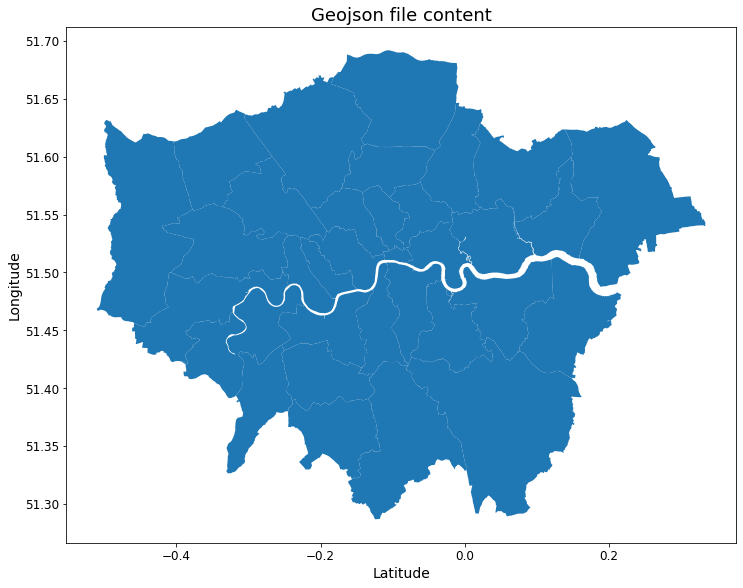

In [71]:
### Plot geojson content

fig = plt.figure(1, (12, 12))
ax = fig.add_subplot(1, 1, 1)

data_neighbourhood['geometry'].plot(ax = ax)

# Format plot
ax.set_title('Geojson file content', fontsize = 18)
ax.set_xlabel('Latitude', fontsize = 14)
ax.set_ylabel('Longitude', fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

fig.show()

Although the geojson file the polygons for each borough, it will not be transformed to a table-like format. Instead, it will be stored in the storage system as it is.